In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import random
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
import numpy as np
from sklearn.cluster import KMeans
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

In [0]:
from __future__ import division

import numpy as np
from sklearn.decomposition import PCA
from copy import deepcopy


class ArtificialBee(object):

    TRIAL_INITIAL_DEFAULT_VALUE = 0
    INITIAL_DEFAULT_PROBABILITY = 0.0

    def __init__(self, obj_function):
        self.pos = obj_function.custom_sample()
        self.obj_function = obj_function
        self.minf = obj_function.minf
        self.maxf = obj_function.maxf
        self.fitness = obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY

    def evaluate_boundaries(self, pos):
        if (pos < self.minf).any() or (pos > self.maxf).any():
            pos[pos > self.maxf] = self.maxf
            pos[pos < self.minf] = self.minf
        return pos

    def update_bee(self, pos, fitness):
        if fitness <= self.fitness:
            self.pos = pos
            self.fitness = fitness
            self.trial = 0
        else:
            self.trial += 1

    def reset_bee(self, max_trials):
        if self.trial >= max_trials:
            self.__reset_bee()

    def __reset_bee(self):
        self.pos = self.obj_function.custom_sample()
        self.fitness = self.obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY


class EmployeeBee(ArtificialBee):

    def explore(self, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(self.pos)
            phi = np.random.uniform(low=-1, high=1, size=len(self.pos))
            n_pos = self.pos + (self.pos - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)
            self.update_bee(n_pos, n_fitness)

    def get_fitness(self):
        return 1 / (1 + self.fitness) if self.fitness >= 0 else 1 + np.abs(self.fitness)

    def compute_prob(self, max_fitness):
        self.prob = self.get_fitness() / max_fitness


class OnLookerBee(ArtificialBee):

    def onlook(self, best_food_sources, max_trials):
        candidate = np.random.choice(best_food_sources)
        self.__exploit(candidate.pos, candidate.fitness, max_trials)

    def __exploit(self, candidate, fitness, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(candidate)
            phi = np.random.uniform(low=-1, high=1, size=len(candidate))
            n_pos = candidate + (candidate - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)

            if n_fitness <= fitness:
                self.pos = n_pos
                self.fitness = n_fitness
                self.trial = 0
            else:
                self.trial += 1


class ABC(object):

    def __init__(self, obj_function, colony_size=30, n_iter=5000, max_trials=100):
        self.colony_size = colony_size
        self.obj_function = obj_function

        self.n_iter = n_iter
        self.max_trials = max_trials

        self.optimal_solution = None
        self.optimality_tracking = []

    def __reset_algorithm(self):
        self.optimal_solution = None
        self.optimality_tracking = []

    def __update_optimality_tracking(self):
        self.optimality_tracking.append(self.optimal_solution.fitness)

    def __update_optimal_solution(self):
        n_optimal_solution = \
            min(self.onlokeer_bees + self.employee_bees,
                key=lambda bee: bee.fitness)
        if not self.optimal_solution:
            self.optimal_solution = deepcopy(n_optimal_solution)
        else:
            if n_optimal_solution.fitness < self.optimal_solution.fitness:
                self.optimal_solution = deepcopy(n_optimal_solution)

    def __initialize_employees(self):
        self.employee_bees = []
        for itr in range(self.colony_size // 2):
            self.employee_bees.append(EmployeeBee(self.obj_function))

    def __initialize_onlookers(self):
        self.onlokeer_bees = []
        for itr in range(self.colony_size // 2):
            self.onlokeer_bees.append(OnLookerBee(self.obj_function))

    def __employee_bees_phase(self):
        map(lambda bee: bee.explore(self.max_trials), self.employee_bees)

    def __calculate_probabilities(self):
        sum_fitness = sum(map(lambda bee: bee.get_fitness(), self.employee_bees))
        map(lambda bee: bee.compute_prob(sum_fitness), self.employee_bees)

    def __select_best_food_sources(self):
        self.best_food_sources =\
            filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1),
                   self.employee_bees)
        while not self.best_food_sources:
            self.best_food_sources = \
                filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1),
                       self.employee_bees)

    def __onlooker_bees_phase(self):
        map(lambda bee: bee.onlook(self.best_food_sources, self.max_trials),
            self.onlokeer_bees)

    def __scout_bees_phase(self):
        map(lambda bee: bee.reset_bee(self.max_trials),
            self.onlokeer_bees + self.employee_bees)

    def optimize(self):
        self.__reset_algorithm()
        self.__initialize_employees()
        self.__initialize_onlookers()
        for itr in range(self.n_iter):
            self.__employee_bees_phase()
            self.__update_optimal_solution()

            self.__calculate_probabilities()
            self.__select_best_food_sources()

            self.__onlooker_bees_phase()
            self.__scout_bees_phase()

            self.__update_optimal_solution()
            self.__update_optimality_tracking()
            print("iter: {} = cost: {}"
                  .format(itr, "%04.03e" % self.optimal_solution.fitness))

In [0]:
from scipy import optimize

class ObjectiveFunction(object):

    def __init__(self, name, dim, minf, maxf):
        self.name = name
        self.dim = dim
        self.minf = minf
        self.maxf = maxf

    def sample(self):
        return np.random.uniform(low=self.minf, high=self.maxf, size=self.dim)

    def custom_sample(self):
        return np.repeat(self.minf, repeats=self.dim) \
               + np.random.uniform(low=0, high=1, size=self.dim) *\
               np.repeat(self.maxf - self.minf, repeats=self.dim)

    
    def evaluate(self, x):
        pass

class PartitionalClusteringObjectiveFunction(ObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(PartitionalClusteringObjectiveFunction, self)\
            .__init__('PartitionalClusteringObjectiveFunction', dim, 0.0, 1.0)
        self.n_clusters = n_clusters
        self.centroids = {}
        self.data = data

    def decode(self, x):
        centroids = x.reshape(self.n_clusters, self.data.shape[1])
        self.centroids = dict(enumerate(centroids))

    def evaluate(self, x):
        pass


class QuantizationError(PartitionalClusteringObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(QuantizationError, self).__init__(dim, n_clusters, data)
        self.name = 'QuantizationError'

    def evaluate(self, x):
        self.decode(x)

        clusters = {key: [] for key in self.centroids.keys()}
        for instance in self.data:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for idx in self.centroids]
            clusters[np.argmin(distances)].append(instance)

        outer_sum = 0.0
        for centroid in self.centroids:
            inner_sum = 0.0
            if len(clusters[centroid]) > 0:
                for instance in clusters[centroid]:
                    inner_sum += np.linalg.norm(instance - self.centroids[centroid])
                inner_sum /= len(clusters[centroid])
            outer_sum += inner_sum
        return outer_sum/len(self.centroids)


class MeanOfSquaredErrors(PartitionalClusteringObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(MeanOfSquaredErrors, self).__init__(dim, n_clusters, data)
        self.name = 'MeanOfSquaredErrors'

    def evaluate(self, x):
        self.decode(x)

        clusters = {key: [] for key in self.centroids.keys()}
        for instance in self.data:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for idx in self.centroids]
            clusters[np.argmin(distances)].append(instance)

        sum_of_squared_errors = 0.0
        for idx in self.centroids:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for instance in clusters[idx]]
            sum_of_squared_errors += np.mean(np.power(distances, 2))
        return sum_of_squared_errors

In [0]:
df=pd.read_csv('/content/drive/My Drive/norm.csv')
df = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)','classs']]
X = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
y = df.classs.values
data = X
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df = pd.concat([principalDf, df[['classs']]], axis = 1)
data = df.drop(columns=['classs']).values

In [0]:
def decode_centroids(centroids, n_clusters, data):
    return centroids.reshape(n_clusters, data.shape[1])

In [7]:
objective_function = MeanOfSquaredErrors(dim=4, n_clusters=2, data=data)
optimizer = ABC(obj_function=objective_function, colony_size=30, n_iter=300, max_trials=100)
optimizer.optimize()

iter: 0 = cost: 1.624e+03
iter: 1 = cost: 1.624e+03
iter: 2 = cost: 1.624e+03
iter: 3 = cost: 1.624e+03
iter: 4 = cost: 1.624e+03
iter: 5 = cost: 1.624e+03
iter: 6 = cost: 1.624e+03
iter: 7 = cost: 1.624e+03
iter: 8 = cost: 1.624e+03
iter: 9 = cost: 1.624e+03
iter: 10 = cost: 1.624e+03
iter: 11 = cost: 1.624e+03
iter: 12 = cost: 1.624e+03
iter: 13 = cost: 1.624e+03
iter: 14 = cost: 1.624e+03
iter: 15 = cost: 1.624e+03
iter: 16 = cost: 1.624e+03
iter: 17 = cost: 1.624e+03
iter: 18 = cost: 1.624e+03
iter: 19 = cost: 1.624e+03
iter: 20 = cost: 1.624e+03
iter: 21 = cost: 1.624e+03
iter: 22 = cost: 1.624e+03
iter: 23 = cost: 1.624e+03
iter: 24 = cost: 1.624e+03
iter: 25 = cost: 1.624e+03
iter: 26 = cost: 1.624e+03
iter: 27 = cost: 1.624e+03
iter: 28 = cost: 1.624e+03
iter: 29 = cost: 1.624e+03
iter: 30 = cost: 1.624e+03
iter: 31 = cost: 1.624e+03
iter: 32 = cost: 1.624e+03
iter: 33 = cost: 1.624e+03
iter: 34 = cost: 1.624e+03
iter: 35 = cost: 1.624e+03
iter: 36 = cost: 1.624e+03
iter: 37 = 

In [8]:
centroids = dict(enumerate(decode_centroids(optimizer.optimal_solution.pos, n_clusters=2, data=data)))
print(centroids)

{0: array([0.85271529, 0.04013282]), 1: array([0.72433055, 0.92022178])}


In [0]:
def assign_centroid(centroids, point):
    distances = [np.linalg.norm(point - centroids[idx]) for idx in centroids]
    return np.argmin(distances)

In [0]:
custom_tgt = []
for instance in data:
    custom_tgt.append(assign_centroid(centroids, instance))
custom = np.array(custom_tgt)

In [0]:
c = []
c.append(list(centroids[0]))
c.append(list(centroids[1]))
c = np.array(c)

In [12]:
dunn(c)

0.08307648495267271

In [13]:
purity_score(y,custom_tgt)

0.6089743589743589

In [16]:
print("Silhouette Coefficient : %0.3f"
      % silhouette_score(data,custom, metric='euclidean'))

Silhouette Coefficient : 0.331


Automatically created module for IPython interactive environment
iter: 0 = cost: 1.624e+03
iter: 1 = cost: 1.624e+03
iter: 2 = cost: 1.624e+03
iter: 3 = cost: 1.624e+03
iter: 4 = cost: 1.624e+03
iter: 5 = cost: 1.624e+03
iter: 6 = cost: 1.624e+03
iter: 7 = cost: 1.624e+03
iter: 8 = cost: 1.624e+03
iter: 9 = cost: 1.624e+03
iter: 10 = cost: 1.624e+03
iter: 11 = cost: 1.624e+03
iter: 12 = cost: 1.624e+03
iter: 13 = cost: 1.624e+03
iter: 14 = cost: 1.624e+03
iter: 15 = cost: 1.624e+03
iter: 16 = cost: 1.624e+03
iter: 17 = cost: 1.624e+03
iter: 18 = cost: 1.624e+03
iter: 19 = cost: 1.624e+03
iter: 20 = cost: 1.624e+03
iter: 21 = cost: 1.624e+03
iter: 22 = cost: 1.624e+03
iter: 23 = cost: 1.624e+03
iter: 24 = cost: 1.624e+03
iter: 25 = cost: 1.624e+03
iter: 26 = cost: 1.624e+03
iter: 27 = cost: 1.624e+03
iter: 28 = cost: 1.624e+03
iter: 29 = cost: 1.624e+03
iter: 30 = cost: 1.624e+03
iter: 31 = cost: 1.624e+03
iter: 32 = cost: 1.624e+03
iter: 33 = cost: 1.624e+03
iter: 34 = cost: 1.624e+03


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter: 0 = cost: 1.659e+03
iter: 1 = cost: 1.659e+03
iter: 2 = cost: 1.659e+03
iter: 3 = cost: 1.659e+03
iter: 4 = cost: 1.659e+03
iter: 5 = cost: 1.659e+03
iter: 6 = cost: 1.659e+03
iter: 7 = cost: 1.659e+03
iter: 8 = cost: 1.659e+03
iter: 9 = cost: 1.659e+03
iter: 10 = cost: 1.659e+03
iter: 11 = cost: 1.659e+03
iter: 12 = cost: 1.659e+03
iter: 13 = cost: 1.659e+03
iter: 14 = cost: 1.659e+03
iter: 15 = cost: 1.659e+03
iter: 16 = cost: 1.659e+03
iter: 17 = cost: 1.659e+03
iter: 18 = cost: 1.659e+03
iter: 19 = cost: 1.659e+03
iter: 20 = cost: 1.659e+03
iter: 21 = cost: 1.659e+03
iter: 22 = cost: 1.659e+03
iter: 23 = cost: 1.659e+03
iter: 24 = cost: 1.659e+03
iter: 25 = cost: 1.659e+03
iter: 26 = cost: 1.659e+03
iter: 27 = cost: 1.659e+03
iter: 28 = cost: 1.659e+03
iter: 29 = cost: 1.659e+03
iter: 30 = cost: 1.659e+03
iter: 31 = cost: 1.659e+03
iter: 32 = cost: 1.659e+03
iter: 33 = cost: 1.659e+03
iter: 34 = cost: 1.659e+03
iter: 35 = cost: 1.659e+03
iter: 36 = cost: 1.659e+03
iter: 37 = 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter: 0 = cost: 0nan
iter: 1 = cost: 0nan
iter: 2 = cost: 0nan
iter: 3 = cost: 0nan
iter: 4 = cost: 0nan
iter: 5 = cost: 0nan
iter: 6 = cost: 0nan
iter: 7 = cost: 0nan
iter: 8 = cost: 0nan
iter: 9 = cost: 0nan
iter: 10 = cost: 0nan
iter: 11 = cost: 0nan
iter: 12 = cost: 0nan
iter: 13 = cost: 0nan
iter: 14 = cost: 0nan
iter: 15 = cost: 0nan
iter: 16 = cost: 0nan
iter: 17 = cost: 0nan
iter: 18 = cost: 0nan
iter: 19 = cost: 0nan
iter: 20 = cost: 0nan
iter: 21 = cost: 0nan
iter: 22 = cost: 0nan
iter: 23 = cost: 0nan
iter: 24 = cost: 0nan
iter: 25 = cost: 0nan
iter: 26 = cost: 0nan
iter: 27 = cost: 0nan
iter: 28 = cost: 0nan
iter: 29 = cost: 0nan
iter: 30 = cost: 0nan
iter: 31 = cost: 0nan
iter: 32 = cost: 0nan
iter: 33 = cost: 0nan
iter: 34 = cost: 0nan
iter: 35 = cost: 0nan
iter: 36 = cost: 0nan
iter: 37 = cost: 0nan
iter: 38 = cost: 0nan
iter: 39 = cost: 0nan
iter: 40 = cost: 0nan
iter: 41 = cost: 0nan
iter: 42 = cost: 0nan
iter: 43 = cost: 0nan
iter: 44 = cost: 0nan
iter: 45 = cost: 0na

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter: 0 = cost: 0nan
iter: 1 = cost: 0nan
iter: 2 = cost: 0nan
iter: 3 = cost: 0nan
iter: 4 = cost: 0nan
iter: 5 = cost: 0nan
iter: 6 = cost: 0nan
iter: 7 = cost: 0nan
iter: 8 = cost: 0nan
iter: 9 = cost: 0nan
iter: 10 = cost: 0nan
iter: 11 = cost: 0nan
iter: 12 = cost: 0nan
iter: 13 = cost: 0nan
iter: 14 = cost: 0nan
iter: 15 = cost: 0nan
iter: 16 = cost: 0nan
iter: 17 = cost: 0nan
iter: 18 = cost: 0nan
iter: 19 = cost: 0nan
iter: 20 = cost: 0nan
iter: 21 = cost: 0nan
iter: 22 = cost: 0nan
iter: 23 = cost: 0nan
iter: 24 = cost: 0nan
iter: 25 = cost: 0nan
iter: 26 = cost: 0nan
iter: 27 = cost: 0nan
iter: 28 = cost: 0nan
iter: 29 = cost: 0nan
iter: 30 = cost: 0nan
iter: 31 = cost: 0nan
iter: 32 = cost: 0nan
iter: 33 = cost: 0nan
iter: 34 = cost: 0nan
iter: 35 = cost: 0nan
iter: 36 = cost: 0nan
iter: 37 = cost: 0nan
iter: 38 = cost: 0nan
iter: 39 = cost: 0nan
iter: 40 = cost: 0nan
iter: 41 = cost: 0nan
iter: 42 = cost: 0nan
iter: 43 = cost: 0nan
iter: 44 = cost: 0nan
iter: 45 = cost: 0na

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter: 0 = cost: 0nan
iter: 1 = cost: 0nan
iter: 2 = cost: 0nan
iter: 3 = cost: 0nan
iter: 4 = cost: 0nan
iter: 5 = cost: 0nan
iter: 6 = cost: 0nan
iter: 7 = cost: 0nan
iter: 8 = cost: 0nan
iter: 9 = cost: 0nan
iter: 10 = cost: 0nan
iter: 11 = cost: 0nan
iter: 12 = cost: 0nan
iter: 13 = cost: 0nan
iter: 14 = cost: 0nan
iter: 15 = cost: 0nan
iter: 16 = cost: 0nan
iter: 17 = cost: 0nan
iter: 18 = cost: 0nan
iter: 19 = cost: 0nan
iter: 20 = cost: 0nan
iter: 21 = cost: 0nan
iter: 22 = cost: 0nan
iter: 23 = cost: 0nan
iter: 24 = cost: 0nan
iter: 25 = cost: 0nan
iter: 26 = cost: 0nan
iter: 27 = cost: 0nan
iter: 28 = cost: 0nan
iter: 29 = cost: 0nan
iter: 30 = cost: 0nan
iter: 31 = cost: 0nan
iter: 32 = cost: 0nan
iter: 33 = cost: 0nan
iter: 34 = cost: 0nan
iter: 35 = cost: 0nan
iter: 36 = cost: 0nan
iter: 37 = cost: 0nan
iter: 38 = cost: 0nan
iter: 39 = cost: 0nan
iter: 40 = cost: 0nan
iter: 41 = cost: 0nan
iter: 42 = cost: 0nan
iter: 43 = cost: 0nan
iter: 44 = cost: 0nan
iter: 45 = cost: 0na

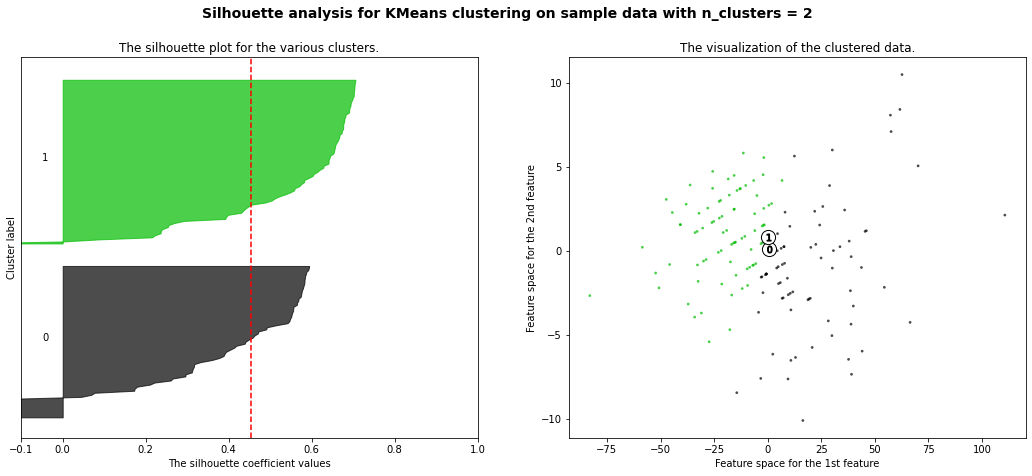

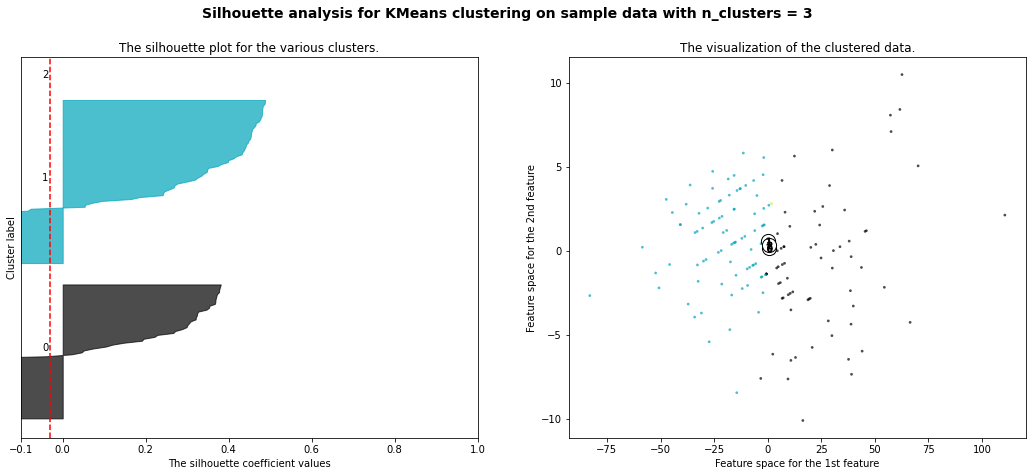

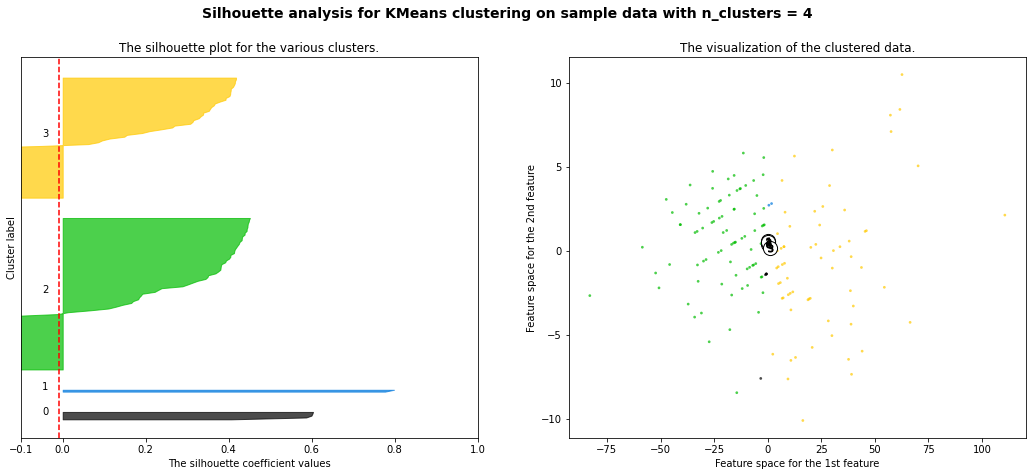

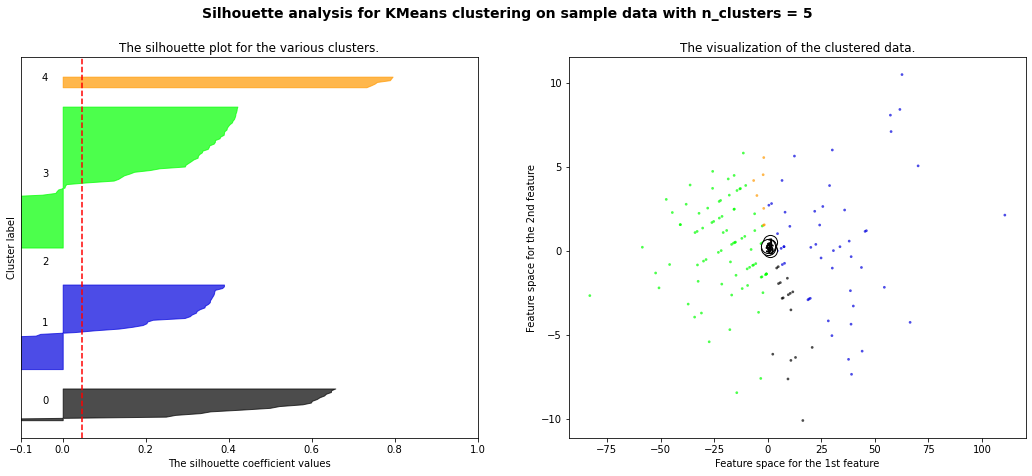

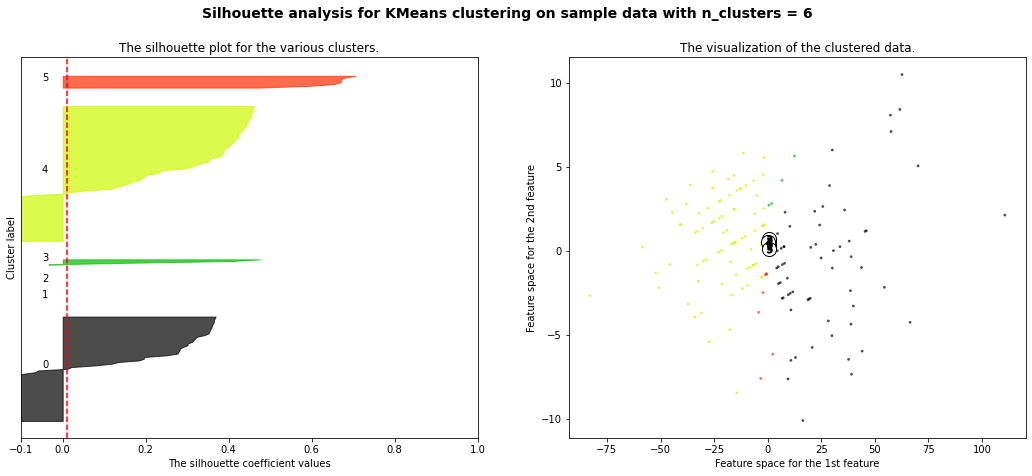

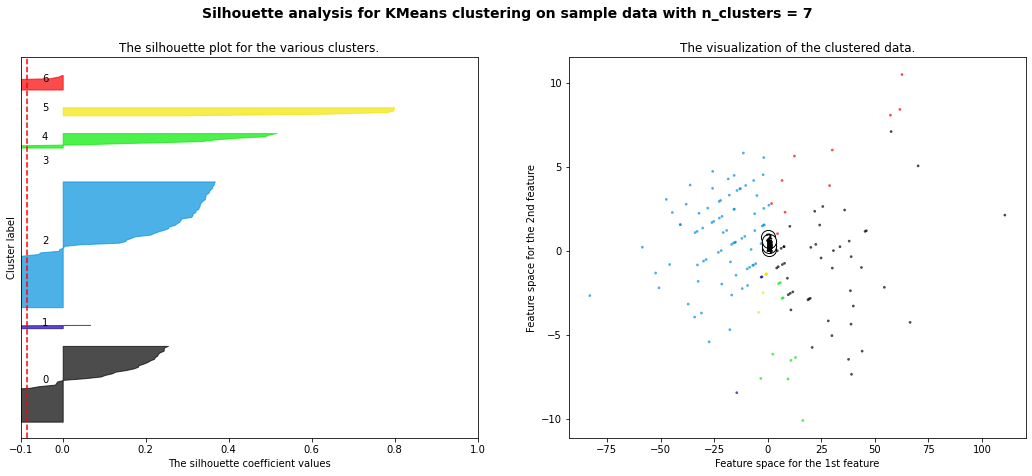

In [54]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
range_n_clusters = [2, 3, 4, 5, 6,7]
X  = data
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    objective_function = MeanOfSquaredErrors(dim=n_clusters*2, n_clusters=n_clusters, data=data)
    optimizer = ABC(obj_function=objective_function, colony_size=30, n_iter=300, max_trials=100)
    optimizer.optimize()
    cents = dict(enumerate(decode_centroids(optimizer.optimal_solution.pos, n_clusters=n_clusters, data=data)))
    cents1 = []
    for i in cents:
      cents1.append(np.array(cents[i]))
    cents1 = np.array(cents1)

    custom_tgt = []
    for instance in data:
      custom_tgt.append(assign_centroid(cents, instance))
    cluster_labels = np.array(custom_tgt)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = cents1
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [51]:
centers

array([0, 1])

In [52]:
cents1

array([0, 1])